## 运行环境
python 3.6.3

Anaconda custom (64-bit)

win10

In [1]:
import numpy as np # 矩阵运算
import matplotlib.pyplot as plt # 绘图
from PIL import Image # 显示图片
import struct # 解析dataset

## 任务定义

handwritten digits recognition

手写体识别

使用全连接的神经网络进行手写体识别

加入正则化, dropout, 并且使用random mini batch 加快训练速度

## 文件到数据

这里是将文件转为numpy的数组进行表示

### 提取图片和标签
得到numpy.ndarray表示的数据, shape如下

```python
trainImage.shape = (60000,28,28)
trainLabel.shape = (60000,1)
testImage.shape = (10000, 28, 28)
testLabel.shape = (10000, 1)
```

In [2]:
with open('train-images.idx3-ubyte','rb') as f:
    trainImage = f.read()
with open('train-labels.idx1-ubyte','rb') as f:
    trainLabel = f.read()
with open('t10k-images.idx3-ubyte','rb') as f:
    testImage = f.read()
with open('t10k-labels.idx1-ubyte','rb') as f:
    testLabel = f.read()

# API : struct.unpack(fmt,bytes)

# bytes -> (int,int,int,int,numpy.ndarray[])
# 接受dataSet原始二进制数据, 返回array, shape为(60000,28,28)
def getImageFromMNIST(imageBytes):
    assert(type(imageBytes) is bytes),'parameter is no bytes'
    magicNum, numOfImages = struct.unpack('>2i',imageBytes[:8]) # 读入校验数据(无用处)和图片数量
    rows, columns = struct.unpack('>2i',imageBytes[8:16]) # 读入图片行数和列数
    imageSize = rows * columns # 行 * 列 = 图片的规模
    # 读入所有图片数据, 总共有 图片规模 * 图片数量 个 unsigned byte
    imageTuple = struct.unpack('>'+str(imageSize * numOfImages)+'B',imageBytes[16:])
    imageArray = np.array(imageTuple) # 数据类型为默认的int
    return imageArray.reshape(numOfImages,rows,columns)

def getLabelFromMNIST(labelBytes):
    assert(type(labelBytes) is bytes),'parameter is no bytes'
    magicNum, numOfLabels = struct.unpack('>2i',labelBytes[:8]) # 读入校验数据(无用处)和标签数量
    # 每个标签大小为unsigned byte, 一次读入所有标签
    labelSize = 1 * numOfLabels
    labelTuple = struct.unpack('>'+str(labelSize)+'B',labelBytes[8:])
    labelArray = np.array(labelTuple) 
    return labelArray.reshape(labelSize,1)

trainImage = getImageFromMNIST(trainImage)
trainLabel = getLabelFromMNIST(trainLabel)
testImage = getImageFromMNIST(testImage)
testLabel = getLabelFromMNIST(testLabel)

print('trainImage.shape:',trainImage.shape)
print('trainLabel.shape:',trainLabel.shape)
print('testImage.shape:',testImage.shape)
print('testLabel.shape:',testLabel.shape)

trainImage.shape: (60000, 28, 28)
trainLabel.shape: (60000, 1)
testImage.shape: (10000, 28, 28)
testLabel.shape: (10000, 1)


## 输入数据定义trainImage, trainLabel, testImage, testLabel

### 预处理数据
$28 \times 28 = 784$

**图片会除以255, 让值落在[0,1]区间上**

$$
value_i = \frac {value_i} {\max(value_i)}
$$

处理后,
```python
trainImage.shape = (784, 60000) # (60000, 28, 28) -> (784, 60000)
trainLabel.shape = (10, 60000)  # (60000,1) -> (10, 60000)
testImage.shape = (784, 10000)  # (10000, 28, 28) -> (784, 10000)
testLabel.shape = (10, 10000)   # (10000, 1) -> (10, 10000)
```

#### 数据含义

如英文名, train代表训练集, test代表测试集, Image代表图片数据, Label代表图片标签
```python
trainImage[:,i]会得到shape = (784,) 的一列数据, 代表一张图片
testLabel[:,i]会得到shape = (10,) 的一列数据, 代表一个标签
```

In [3]:
# (number, 28, 28) -> (784, number)
def changeImage(image):
    image = image.reshape(-1,28*28)
    image = image.T # 转置, 让图片数据变为列表示
    image = image.astype(np.float16) # 重置数据类型为numpy.float16
    return image / 255.0 # 归一化, 让值落在[0,1]上, 方便训练

# (number, 1) -> (10, number)
def changeLabel(label):
    assert(label.shape[1] == 1)
    column = np.arange(10) # get 0~9, shape = (10,)
    column = column.reshape(10,1) # to column
    return label.T == column # use broadcasting to generate True or False label
    
trainImage = changeImage(trainImage)
trainLabel = changeLabel(trainLabel)
testImage = changeImage(testImage)
testLabel = changeLabel(testLabel)

print('trainImage.shape:',trainImage.shape)
print('trainLabel.shape:',trainLabel.shape)
print('testImage.shape:',testImage.shape)
print('testLabel.shape:',testLabel.shape)

trainImage.shape: (784, 60000)
trainLabel.shape: (10, 60000)
testImage.shape: (784, 10000)
testLabel.shape: (10, 10000)


## 方法描述

### 激活函数

隐层都使用Relu激活函数, 输出层使用softmax

### 损失函数(使用了交叉熵) (Extra!)



$$
对于每个数据, 使用交叉熵, Lost = - \sum _{j=0} ^{9} y_j \ln a_j
$$

* $y_j$ : 实际值, 0或1
* $\ln a_j$ : 激活值(预测值), 小数

### L2正则化

$$
Cost = \sum _{i=1} ^{m} Lost_i + \frac {\lambda} {2} \sum _ W \Vert {W} \Vert ^2
$$

* $\lambda$ : L2正则化系数
* W : 网络层与网络层之间的权重矩阵


### dropout (Extra!)

有2个dropout

* 在隐层(hidden layers)上的dropout
* 在输入层(input layers)上的dropout

### random mini batch (Extra!)

为了加快训练速度, 使用了随机mini batch

可调batch size, 这里使用128的batch size

即在每次迭代中, 会从训练集中随机挑选128个样本以及其对应的标签来进行正向传播, 反向传播, 更新参数

### 载入自己实现的神经网络模块

In [4]:
import os
import importlib # 使用这个可以重新import模块
import NN # 自己写的神经网络模块

my Neural Network import succeed


### 初始化网络

#### 网络层数及数量: 下方cell里的代码

#### w和b

$w = randn(L_i, L_{i-1}) \times \sqrt{\frac 2 {L_{i-1}}}$

$b = 0, shape = (L_i, 1)$

* $L_i$ : 第i层网络的节点数量

对应代码为

```python
self.parameters['W'+str(i)] = np.random.randn(layers[i],layers[i-1]) * np.sqrt(2 / layers[i-1])
self.parameters['b'+str(i)] = np.zeros((layers[i],1))
```

#### L2正则化系数$\lambda = 0.001$

#### dropout

* 在隐层(hidden layers)上的dropout: 下方代码
* 在输入层(input layers)上的dropout: 下方代码

#### mini bath size : 128

#### 学习率

恒定学习率，但是可以停下来，修改学习率后，继续训练

手动控制学习率和迭代次数

对每次的训练进行多重组合

In [5]:
np.random.seed(1) # 改变随机数种子, 方便复现bug
data = { # 训练数据
'trainX':trainImage,
'trainY':trainLabel
}

layers = [784,500, 300, 200, 10] # 784代表输入数据规模, layers[i] 代表第 i 层网络的节点数
print('layers info:',layers)

hy = {
    'open-dropout': True,
    'dropout': 0.8,
    'dropout-input': 0.9
}

#######################################################

relu = lambda z:np.maximum(0.01 * z,z) # Relu 激活函数
relu_deriv = lambda z,a:np.where(z > 0,1.0,0.01) # Relu 激活函数的导数

def lostFunc(A,Y):
    assert(A.shape == Y.shape),'A.shape != Y.shape'
    # A and Y are matrix, but we just want to operation on column, so use axis = 0
    ylna = np.multiply(Y,np.log(A+1e-10)) # add 1e-10 to forbidden np.log(0)
    return -np.sum(ylna,axis = 0,keepdims=True) # remember add minus symbol "-"
    
def softmax(Z): # Z is a column vector, but we need to handle when Z is a matrix, use axis = 0
    maxNumber = np.max(Z,axis = 0,keepdims=True)
    assert(Z.shape[1] == maxNumber.shape[1])
    Z -= maxNumber
    Zexp = np.exp(Z)
    return Zexp / np.sum(Zexp,axis = 0,keepdims=True)

def softmax_deriv(Z,A,Y): # softmax 的导数
    assert(A.shape == Y.shape),'A.shape is not same as Y.shape'
    return A - Y



def getFunction(layers): # 初始化function
    function = {
                'activation':{},
                'derivative':{},
                'lostFunction':lostFunc, # lambda a,y:np.sum(np.multiply(-y,np.log(a)),axis = 0), # (AL,Y) -> Lost(AL,Y)
                'predictFunction':lambda A:(A,A>=np.max(A,axis = 0)), # (A,preA)
                'accuracyFunction':lambda A,Y:1.0/Y.shape[1] * np.sum((np.sum(A==Y,axis = 0,keepdims=True) == 10))
                }
    L = len(layers) - 1
    for i in range(1,L):
        function['activation'][i] = relu
        function['derivative'][i] = relu_deriv
    function['activation'][L] = softmax
    function['derivative'][L] = lambda Z,A,Y:softmax_deriv(Z,A,Y)
    return function

function = getFunction(layers)

importlib.reload(NN) # 重新import模块, 便于修改后重新import
myNN = NN.NN(data, layers, function, hy) # 初始化网络!!!!!!

layers info: [784, 500, 300, 200, 10]
my Neural Network import succeed
L2 regularition: lambda = 0.001
open-dropout: True
Dropout in hidden layers: keep probility is 0.8
dropout in input: keep probility is 0.9


#### 开始训练

学习率为`learningRate`, 阶梯式降低

batchSize = 128

每次的迭代次数不同

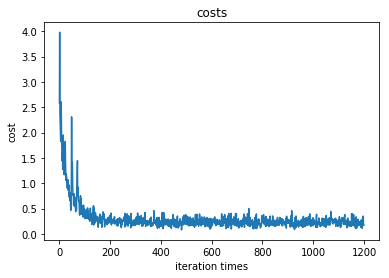

delete dropout in input
train accuracy: 0.951183333333
test 1~10000 accuracy: 0.9507
test 1~5000 accuracy: 0.9316
test 5000~10000 accuracy: 0.9698


In [6]:

costs = myNN.miniBatchRandom(learningRate=0.7,batchSize=128,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.4,batchSize=128,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.1,batchSize=128,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.02,batchSize=128,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.0001,batchSize=128,batchTimes=200,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.000001,batchSize=128,batchTimes=300,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.0000001,batchSize=128,batchTimes=300,getCost=True)

# 绘制cost函数曲线

plt.plot(costs)
plt.title('costs')
plt.xlabel("iteration times")
plt.ylabel("cost")
plt.show()

# 在预测时候，将输入的dropout删除
if "dropout-input" in myNN.hyperParameters: 
    print('delete dropout in input')
    myNN.hyperParameters.pop('dropout-input')
else:
    pass

trainPre,trainPreBool = myNN.predict(X=trainImage)
print('train accuracy:',myNN.accuracy(trainPreBool,trainLabel))

testPre,testPreBool = myNN.predict(X=testImage)
print('test 1~10000 accuracy:',myNN.accuracy(testPreBool,testLabel))

testPre,testPreBool = myNN.predict(X=testImage[:,:5000])
print('test 1~5000 accuracy:',myNN.accuracy(testPreBool,testLabel[:,:5000])) # 前5000个样本的正确率

testPre,testPreBool = myNN.predict(X=testImage[:,5000:])
print('test 5000~10000 accuracy:',myNN.accuracy(testPreBool,testLabel[:,5000:])) # 后5000个样本的正确率

## 检测算法正确性(测试用)

在作业中保留是因为在写文档的时候，也需要做一些测试，检查的时候可以跳过这里

真实标签:
[(0, False), (1, False), (2, False), (3, False), (4, False), (5, False), (6, False), (7, True), (8, False), (9, False)]


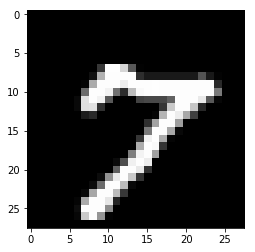

------------------------------
预测标签
[(0, False), (1, False), (2, False), (3, False), (4, False), (5, False), (6, False), (7, True), (8, False), (9, False)]
[(0, 1.3714188931402748e-07), (1, 1.8635584460685532e-07), (2, 1.3587651531713982e-05), (3, 1.0279929564502249e-05), (4, 9.768556236529011e-08), (5, 3.229558768236209e-07), (6, 1.2364115392022533e-09), (7, 0.9999016456420643), (8, 6.36921585199199e-08), (9, 7.367770909622921e-05)]


In [7]:
list2boolTuple = lambda l:list(zip(range(10), l)) # list 到二元组（数字，bool），方便查看结果

index = 9000 # 选中的测试图片
print("真实标签:")
print(list2boolTuple(testLabel[:,index]))
nowPre,nowPreBool = myNN.predict(X = testImage[:,index].reshape(-1,1))
nowImage = testImage[:,index]
nowImage = np.array(nowImage) # 创建新数据, 防止数据被改变
nowImage = nowImage.reshape(28,28) # 返回图片的原始形状
nowImage *= 255 # 恢复为0~255的灰度值
nowImage = nowImage.astype(int) # float不支持转为图片, 所以用int

plt.imshow(Image.fromarray(nowImage))
plt.show()
print('-'*30)
print("预测标签")
print(list2boolTuple(nowPreBool.T.tolist()[0]))
print(list2boolTuple(nowPre.T.tolist()[0]))

## 测试自己的图片

会打开自己本地画的一张名为“number.bmp”的图片

然后用训练好的神经网络来看看这个图片应该被归类到哪个数字

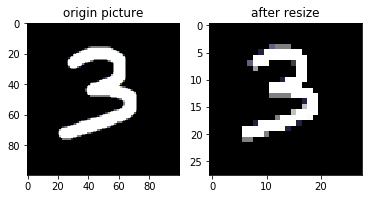

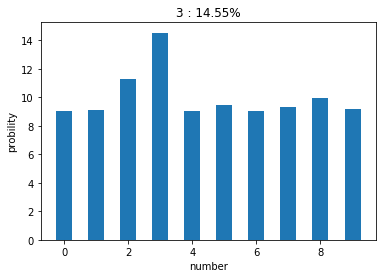

In [8]:
myNumber = Image.open('number.bmp') # 打开图片,注意图片本身的格式, 如果是256色模式, 就不用将RGB相加了

plt.subplot(121)
plt.imshow(myNumber) # 显示图片
plt.title('origin picture')

plt.subplot(122)
myNumber = myNumber.resize((28,28),Image.ANTIALIAS) # 重置大小, 宽度为28, 高度为28
plt.imshow(myNumber) # 显示resize后的图片
plt.title('after resize')
plt.show()


myNumberArr = np.array(myNumber) # 从图片获取 array
# print(myNumberArr.shape)

# 归一化后才可以predict
myNumberArr = myNumberArr / 255
myNumberArr = myNumberArr.reshape(28*28,1)
myPre,myPreBool = myNN.predict(X=myNumberArr)

# print(myPreBool.T)
# plt.figure()
probablity = (softmax(myPre).T.reshape(10,) * 100).tolist()
# print(probablity)
preNumber = probablity.index(max(probablity))
plt.title(str(preNumber)+' : '+str(round(max(probablity),2))+'%')
plt.bar([i for i in range(10)],probablity,[0.5 for i in range(10)], \
        align = 'center')
plt.xlabel("number")
plt.ylabel("probility")
plt.show()

## 结果分析

### hyperparameters分析

我用的参数是, 输入层为784

隐层有3层, 分别为500, 300, 200

输出层为10

L2正则化中的lambda系数为0.001

dropout在输入层上为0.9, 在隐层上为0.8

### 训练集分析与测试集分析

测试集上对于全部总共10000张图片的正确率为`0.9507`
对于前5000张图片的正确率为`0.9316`,
后5000张图片的正确率为`0.9698`
符合在数据描述文档中，前5000张图片较难识别的描述

训练集上的正确率为`0.951183333333`

训练集和测试集的正确率均为95%左右，方差较大，但是偏差较小(cost相差较小)

图片的识别率有待提高, 因为无论在训练集, 还是在测试集上, 识别率都只有95%左右

overfitting貌似没有出现

